# Spatially Informed Traveling Salesman Problem
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Rw9_fomI2CRgYNwEmZRx8XU3j1RQK9gO)
Developed by Wanhee Kim(Phd student at UTK) / Revised Date : 04/09/2024


## Sequence of spatially informed TSP
0. Pre-setting for the Analysis
1. Generate distance matrix regarding on Spatial adjacency
2. Generate LP Model for Analyzing TSP
3. Analyze by using CPLEX(Solving machine)

## Analysis

0. Pre-Setting for Analysis

In [ ]:
pip install spatialtsp

In [1]:
# change path
import os
os.chdir('D:/GIS program/Github/spatialtsp/spatialtsp-5')

# Check the directory
# current_directory = os.getcwd()
# print("current directory:", current_directory)

# import spatialtsp
# print(dir(spatialtsp))

# # set working directory
# path = 'D:/GIS program/Github/spatialtsp/final_work'
# os.chdir(path)
# os.getcwd()

In [2]:
# Import the package
from spatialtsp import generate_clustered_points, generate_random_points, calculate_distance_matrix, voronoi_adjacency_distance, knn_adjacency_distance, combine_distance_matrices, generate_lp_model, get_attributes_cplex, writeLpFile_func

In [ ]:
#print(dir(spatialtsp))

## Test in Toy Data

1. Generate Distance Matrix(standard vs Spatially Informed)

In [3]:
# 1) Generate points
points=generate_random_points(7) # Generate Stratified random points. 7*7 = 49

#print(points)

In [4]:
# 2) Calculate Standard Distance Matrix
distance_matrix=calculate_distance_matrix(points)
distance_matrix

array([[   0,  817, 1417, ..., 5316, 5422, 6248],
       [ 817,    0,  793, ..., 4775, 4840, 5608],
       [1417,  793,    0, ..., 5086, 5097, 5766],
       ...,
       [5316, 4775, 5086, ...,    0,  365, 1311],
       [5422, 4840, 5097, ...,  365,    0,  994],
       [6248, 5608, 5766, ..., 1311,  994,    0]])

In [5]:
# 3) Calculate Distance Matrix with the concept of adjacency : by using Voronoi concept and K-NN concept
Voronoi_distance, voronoi_polygon = voronoi_adjacency_distance(points)
KNN_distance = knn_adjacency_distance(points, k=7)
combined_distance = combine_distance_matrices(Voronoi_distance, KNN_distance) # Combine the two distance matrices

# Print the distance matrices
print(Voronoi_distance)
print(KNN_distance)
print(combined_distance)

[[    0   817 99999 ... 99999 99999 99999]
 [  817     0   793 ... 99999 99999 99999]
 [99999   793     0 ... 99999 99999 99999]
 ...
 [99999 99999 99999 ...     0   365 99999]
 [99999 99999 99999 ...   365     0   994]
 [99999 99999 99999 ... 99999   994     0]]
[[    0   817  1417 ... 99999 99999 99999]
 [  817     0   793 ... 99999 99999 99999]
 [ 1417   793     0 ... 99999 99999 99999]
 ...
 [99999 99999 99999 ...     0   365 99999]
 [99999 99999 99999 ...   365     0   994]
 [99999 99999 99999 ...  1311   994     0]]
[[    0   817  1417 ... 99999 99999 99999]
 [  817     0   793 ... 99999 99999 99999]
 [ 1417   793     0 ... 99999 99999 99999]
 ...
 [99999 99999 99999 ...     0   365 99999]
 [99999 99999 99999 ...   365     0   994]
 [99999 99999 99999 ...  1311   994     0]]


In [6]:
# Export shp files
path = 'D:/GIS program/Github/spatialtsp/spatialtsp-5'
points.to_file('{}/final_work/03_LPFiles/test.shp'.format(path), encoding='utf-8')
voronoi_polygon.to_file('{}/final_work/03_LPFiles/test_polygon.shp'.format(path), encoding='utf-8')

### 2. Generate LP Model

2-1. Make LP files

In [7]:
# Standard version
lp_model = generate_lp_model(distance_matrix)
# Spatially Informed version
lp_model_2 = generate_lp_model(combined_distance)

print(lp_model)
print(lp_model_2)

\* Generated LP model for 49 points.*/
\* Generated LP model for 49 points.*/
Minimize
obj: 817 X_1_2 + 1417 X_1_3 + 2164 X_1_4 + 2866 X_1_5 + 3582 X_1_6 + 4151 X_1_7 + 836 X_1_8 + 1246 X_1_9 + 1847 X_1_10 + 2507 X_1_11 + 3096 X_1_12 + 4144 X_1_13 + 4614 X_1_14 + 1486 X_1_15 + 1185 X_1_16 + 2095 X_1_17 + 2815 X_1_18 + 2978 X_1_19 + 4164 X_1_20 + 4425 X_1_21 + 1607 X_1_22 + 2256 X_1_23 + 2640 X_1_24 + 3309 X_1_25 + 3408 X_1_26 + 4029 X_1_27 + 5125 X_1_28 + 2866 X_1_29 + 2664 X_1_30 + 2928 X_1_31 + 3470 X_1_32 + 4013 X_1_33 + 4559 X_1_34 + 5442 X_1_35 + 3476 X_1_36 + 3340 X_1_37 + 3736 X_1_38 + 4400 X_1_39 + 4595 X_1_40 + 5360 X_1_41 + 5549 X_1_42 + 3778 X_1_43 + 4372 X_1_44 + 4477 X_1_45 + 4631 X_1_46 + 5316 X_1_47 + 5422 X_1_48 + 6248 X_1_49 + 817 X_2_1 + 793 X_2_3 + 1378 X_2_4 + 2085 X_2_5 + 2782 X_2_6 + 3341 X_2_7 + 793 X_2_8 + 718 X_2_9 + 1132 X_2_10 + 1723 X_2_11 + 2292 X_2_12 + 3327 X_2_13 + 3798 X_2_14 + 1688 X_2_15 + 829 X_2_16 + 1358 X_2_17 + 2081 X_2_18 + 2204 X_2_19 + 3380 X_

2-2. Write the LP file

In [8]:
# Standard version
file_path = f"{path}/final_work/03_LPFiles/TSP_test.lp" 
with open(file_path, 'w') as file:
    file.write(lp_model)
print(f"LP file saved to {file_path}")

# Spatially Informed version
file_path = f"{path}/final_work/03_LPFiles/TSP_test_2.lp" 
with open(file_path, 'w') as file:
    file.write(lp_model_2)
print(f"LP file saved to {file_path}")

LP file saved to D:/GIS program/Github/spatialtsp/spatialtsp-5/final_work/03_LPFiles/TSP_test.lp
LP file saved to D:/GIS program/Github/spatialtsp/spatialtsp-5/final_work/03_LPFiles/TSP_test_2.lp


### 3. Run LP Model

In [9]:
# Import the package
import subprocess
import pandas as pd

Standard TSP

In [10]:
# Define the path to the LP file
lp_file_path = f'"{path}/final_work/03_LPFiles/TSP_test.lp"'

# Initialize lists to store results
objval_ls = []
nodenb_ls = []
timenb_ls = []
iternb_ls = []
dettime_ls = []

# Run CPLEX
command = [
    'D:/GIS program/cplex_2018-20230804T132516Z-003/cplex/bin/x64_win64/cplex.exe', '-c',
    f'read {lp_file_path}',
    'set threads 2',
    'set timelimit 3600',
    'opt', 
    'display solution variables -'
]
try:
    r = subprocess.run(command, capture_output=True, text=True, check=True)
    print("STDOUT:", r.stdout)
    print("STDERR:", r.stderr)
except subprocess.CalledProcessError as e:
    print("Error:", e)
    print("STDERR:", e.stderr)

# Get the attributes by running CPLEX
result = r.stdout
timenb, iternb, nodenb, objval, dettime, variables = get_attributes_cplex(result)
print(f"Objective: {objval}, Solution Time: {timenb}, Iterations: {iternb}, Nodes: {nodenb}, Dettime: {dettime}")
print("Variables:", variables)

# Append the results to the lists
objval_ls.append(objval)  
timenb_ls.append(timenb)  
iternb_ls.append(iternb)  
nodenb_ls.append(nodenb) 
dettime_ls.append(dettime) 

loc_dict = {
    'ObjVal': objval_ls, 
    'Nodenb': nodenb_ls, 
    'Timenb': timenb_ls, 
    'Iternb': iternb_ls, 
    'Dettime': dettime_ls,
    'Variables': [variables]
     #'Geogetry' : geometry_ls

}
df_1 = pd.DataFrame(loc_dict)

df_1

STDOUT: 
Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Problem 'D:/GIS program/Github/spatialtsp/spatialtsp-5/final_work/03_LPFiles/TSP_test.lp' read.
Read time = 0.00 sec. (0.30 ticks)
CPLEX> New value for default parallel thread count: 2
CPLEX> New value for time limit in seconds: 3600
CPLEX> CPXPARAM_TimeLimit                               3600
CPXPARAM_Threads                                 2
Tried aggregator 1 time.
MIP Presolve modified 4512 coefficients.
Reduced MIP has 2354 rows, 2400 columns, and 11472 nonzeros.
Reduced MIP has 2352 binaries, 48 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (6.17 ticks)
Probing time = 0.00 sec. (4.19 ticks)
Tried agg

,ObjVal,Nodenb,Timenb,Iternb,Dettime,Variables
0,31220.0,5774,10.67,94219,14549.21,"{'X_1_8': 1.0, 'X_2_1': 1.0, 'X_3_2': 1.0, 'X_..."


Spatially Informed TSP

In [11]:
import subprocess
import pandas as pd

lp_file_path_2 = f'"{path}/final_work/03_LPFiles/TSP_test_2.lp"'

# Initialize lists to store results
objval_ls = []
nodenb_ls = []
timenb_ls = []
iternb_ls = []
dettime_ls = []

# Run CPLEX
command = [
    'D:/GIS program/cplex_2018-20230804T132516Z-003/cplex/bin/x64_win64/cplex.exe', '-c',
    f'read {lp_file_path_2}',
    'set threads 2',
    'set timelimit 3600',
    'opt',
    'display solution variables -'
]
try:
    r = subprocess.run(command, capture_output=True, text=True, check=True)
    print("STDOUT:", r.stdout)
    print("STDERR:", r.stderr)
except subprocess.CalledProcessError as e:
    print("Error:", e)
    print("STDERR:", e.stderr)

# Get the attributes by running CPLEX
result = r.stdout
timenb, iternb, nodenb, objval, dettime, variables = get_attributes_cplex(result)
print(f"Objective: {objval}, Solution Time: {timenb}, Iterations: {iternb}, Nodes: {nodenb}, Dettime: {dettime}")
print("Variables:", variables)

# Append the results to the lists
objval_ls.append(objval)  
timenb_ls.append(timenb)  
iternb_ls.append(iternb)  
nodenb_ls.append(nodenb) 
dettime_ls.append(dettime) 

loc_dict = {
    'ObjVal': objval_ls, 
    'Nodenb': nodenb_ls, 
    'Timenb': timenb_ls, 
    'Iternb': iternb_ls, 
    'Dettime': dettime_ls,
    'Variables': [variables]
     #'Geogetry' : geometry_ls
}
df_2 = pd.DataFrame(loc_dict)

df_2

STDOUT: 
Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Problem 'D:/GIS program/Github/spatialtsp/spatialtsp-5/final_work/03_LPFiles/TSP_test_2.lp' read.
Read time = 0.00 sec. (0.30 ticks)
CPLEX> New value for default parallel thread count: 2
CPLEX> New value for time limit in seconds: 3600
CPLEX> CPXPARAM_TimeLimit                               3600
CPXPARAM_Threads                                 2
Tried aggregator 1 time.
MIP Presolve modified 4512 coefficients.
Reduced MIP has 2354 rows, 2400 columns, and 11472 nonzeros.
Reduced MIP has 2352 binaries, 48 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (6.17 ticks)
Probing time = 0.02 sec. (4.19 ticks)
Tried a

,ObjVal,Nodenb,Timenb,Iternb,Dettime,Variables
0,31220.0,4544,1.81,76011,2643.11,"{'X_1_2': 1.0, 'X_2_3': 1.0, 'X_3_4': 1.0, 'X_..."


In [15]:
# Variables means the order of the points for tour
print(variables)

tour_order = [(int(k.split('_')[1]), int(k.split('_')[2])) for k, v in variables.items() if v == 1.0]

print(tour_order)

{'X_1_2': 1.0, 'X_2_3': 1.0, 'X_3_4': 1.0, 'X_4_5': 1.0, 'X_5_6': 1.0, 'X_6_7': 1.0, 'X_7_13': 1.0, 'X_8_1': 1.0, 'X_9_16': 1.0, 'X_10_9': 1.0, 'X_11_17': 1.0, 'X_12_11': 1.0, 'X_13_14': 1.0, 'X_14_21': 1.0, 'X_15_8': 1.0, 'X_16_22': 1.0, 'X_17_10': 1.0, 'X_18_19': 1.0, 'X_19_12': 1.0, 'X_20_27': 1.0, 'X_21_20': 1.0, 'X_22_15': 1.0, 'X_23_24': 1.0, 'X_24_31': 1.0, 'X_25_26': 1.0, 'X_26_18': 1.0, 'X_27_34': 1.0, 'X_28_35': 1.0, 'X_29_30': 1.0, 'X_30_23': 1.0, 'X_31_32': 1.0, 'X_32_33': 1.0, 'X_33_25': 1.0, 'X_34_28': 1.0, 'X_35_41': 1.0, 'X_36_29': 1.0, 'X_37_43': 1.0, 'X_38_37': 1.0, 'X_39_46': 1.0, 'X_40_39': 1.0, 'X_41_42': 1.0, 'X_42_49': 1.0, 'X_43_36': 1.0, 'X_44_38': 1.0, 'X_45_44': 1.0, 'X_46_45': 1.0, 'X_47_40': 1.0, 'X_48_47': 1.0, 'X_49_48': 1.0}
[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 13), (8, 1), (9, 16), (10, 9), (11, 17), (12, 11), (13, 14), (14, 21), (15, 8), (16, 22), (17, 10), (18, 19), (19, 12), (20, 27), (21, 20), (22, 15), (23, 24), (24, 31), (25, 26), 

Visualize the results

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

In [20]:
# Read the shapefiles(points and polygons) for visualization
polygon_path = "D:\\GIS program\\Github\\spatialtsp\\spatialtsp-5\\final_work\\03_LPFiles\\test_polygon.shp"
point_path = "D:\\GIS program\\Github\\spatialtsp\\spatialtsp-5\\final_work\\03_LPFiles\\test.shp"
gdf_points = gpd.read_file(point_path)
gdf_polygons = gpd.read_file(polygon_path)

In [27]:
print(gdf_points.columns)

Index(['FID', 'geometry'], dtype='object')


In [32]:
print(gdf_points['FID'].dtype)

int64


In [33]:
print(49 in gdf_points['FID'].values)

False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


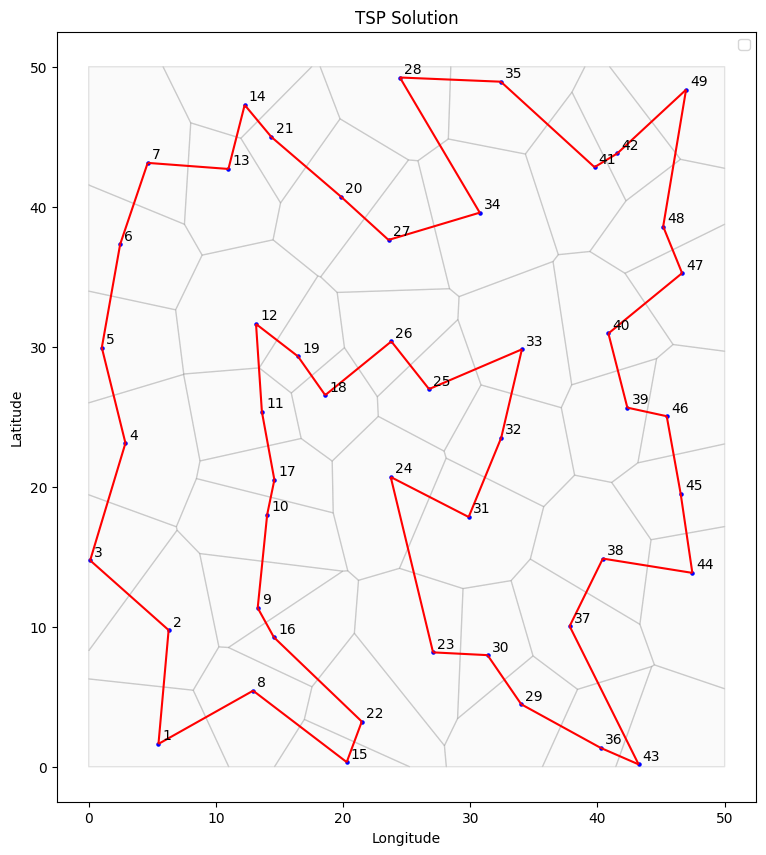

In [35]:
def find_point(fid):
    try:
        point = gdf_points[gdf_points['FID'] == fid-1].geometry.iloc[0]
        return point
    except IndexError:
        raise ValueError(f"No geometry found for FID {fid}. Check if the FID is correct and present in gdf_points.")

# Generate lines for the tour
lines = [LineString([find_point(start), find_point(end)]) for start, end in tour_order]

# # Create a GeoDataFrame for the lines
gdf_lines = gpd.GeoDataFrame(geometry=lines, crs=gdf_points.crs)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_polygons.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.1)
gdf_points.plot(ax=ax, marker='o', color='blue', markersize=5)
gdf_lines.plot(ax=ax, linewidth=1.5, color='red')

# Adding labels
for Input_FID, row in gdf_points.iterrows():
    ax.annotate(text=Input_FID+1, xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", color='black')

ax.set_title('TSP Solution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()

### Application into 48 Capitals of US

In [ ]:
# Import the package
import numpy as np
import geopandas as gpd

In [ ]:
# Read the shapefiles
# polygon_path = "C:\\Users\\dooco\\OneDrive\\spatial data\\US_Data\\TSP_dataset\\SpatialData\\Capitals_Voronoi_clipped.shp"
# point_path = "C:\\Users\\dooco\\OneDrive\\spatial data\\US_Data\\TSP_dataset\\SpatialData\\Capitals_Points.shp"

# US_points = gpd.read_file(point_path)
# #US_points = np.array(list(gdf_points.geometry.apply(lambda geom: (geom.x, geom.y))))

In [ ]:
# Calculate the distance matrix
# distance_matrix=calculate_distance_matrix(US_points)
# distance_matrix

In [ ]:
# Calculate the distance matrix with the concept of adjacency
# Voronoi_distance = voronoi_adjacency_distance(US_points)
# KNN_distance = knn_adjacency_distance(US_points, k=7)
# combined_distance = combine_distance_matrices(Voronoi_distance, KNN_distance)
# combined_distance

In [ ]:
# set working directory
# import os

# path = 'D:/GIS_analyzing/1.Standard_TSP/0.test_iteration' # write your own directory
# os.chdir(path)
# os.getcwd()

In [ ]:
## other codes will be updated soon

## Display Basemap

In [ ]:
## Add basemap
from spatialtsp import Map

my_map = Map(center=[40.7128, -74.0060], zoom=10)
my_map.add_basemap("OpenStreetMap.Mapnik")

my_map


In [ ]:
## Add GeoJSON
from spatialtsp import Map

geojson_map = Map(center=[37.0902, -95.7129], zoom=4)
geojson_url = "https://github.com/opengeos/datasets/releases/download/us/us_states.geojson"
geojson_map.add_geojson(geojson_url, name="US Counties")

geojson_map


In [ ]:
## Add shp
import geopandas as gpd
import requests
import zipfile
import io
from spatialtsp import Map

# Shapefile URL
url = 'https://github.com/opengeos/datasets/releases/download/us/us_states.zip'

# Download and extract the zip file
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Find the shapefile name
shp_name = [name for name in z.namelist() if '.shp' in name][0]

# Read and extract the shapefile
z.extractall("temp_shp")
states_gdf = gpd.read_file("temp_shp/us_states.shp")


# Display the shapefile
my_map = Map(center=[37.0902, -95.7129], zoom=4)
my_map.add_vector(states_gdf, name="US States")

my_map


In [ ]:
## Add Vector
from spatialtsp import Map

# Initialize the map
my_map = Map(center=[37.0902, -95.7129], zoom=4)

# GeoJSON URLs
city_geojson_url = "https://github.com/opengeos/datasets/releases/download/us/us_cities.geojson"
county_geojson_url = "https://github.com/opengeos/datasets/releases/download/us/us_counties.geojson"

# Shapefile URL
states_shape_url = 'https://github.com/opengeos/datasets/releases/download/us/us_states.zip'

# Load GeoJSONs as GeoDataFrames
gdf_cities = gpd.read_file(city_geojson_url)
gdf_counties = gpd.read_file(county_geojson_url)

# Use add_vector to add GeoDataFrames to the map
my_map.add_vector(gdf_counties, name="US Counties")
my_map.add_vector(gdf_cities, name="US Cities")
# For the shapefile, directly use the URL
my_map.add_vector(states_shape_url, name="US States")

# Display the map
my_map

##Raster Map

In [ ]:
#change path
import os
os.chdir('D:/GIS program/Github/spatialtsp/spatialtsp-5')

In [ ]:
# import functions
!pip install localtileserver
import spatialtsp
from spatialtsp import Map

In [ ]:
# check the path of functions
from importlib import reload
reload(spatialtsp)

from spatialtsp import Map
m = Map()
print(dir(m)) 

import spatialtsp
print(spatialtsp.__file__)

In [ ]:
## overlay climate image(png)
from ipyleaflet import Map, ImageOverlay

m = Map(center=(25, -115), zoom=4)

image = ImageOverlay(
    url="https://i.imgur.com/06Q1fSz.png",
    # url='../06Q1fSz.png',
    bounds=((13, -130), (32, -100)),
)

m.add(image)
m

In [ ]:
## Overlay GIF of TSP into basemap
m = Map(center=(40, -100), zoom=4)

url = "https://graphdeeplearning.github.io/project/combinatorial-optimization/tsp-gif.gif"

# url='../06Q1fSz.png',
bounds = ((25, -125), (51, -66))
m.add_image(url, bounds)
m.add_layers_control()
# m.scroll_wheel_zoom = True
m

In [ ]:
## Overlay COloud Optimized GeoTiff into Basemap
from localtileserver import TileClient, get_leaflet_tile_layer, examples
from spatialtsp import Map

client = TileClient(
    "https://github.com/opengeos/datasets/releases/download/raster/srtm90.tif"
)

# Create ipyleaflet TileLayer from that server
t = get_leaflet_tile_layer(client)
# Create ipyleaflet map, add tile layer, and display
m = Map()
m.add(t)
m.center = client.center()
m.zoom = client.default_zoom
m